# MecabとNaïveBayesを用いた文豪の文章データの分類
08-182024 松井誠泰
## 環境構築
ネット上に古いデータが多く、戸惑ったので、一応メモ。MacOS High Sierraなので、ECCSでも再現できると思います(Pythonは3系を使用)。
```
brew install mecab mecab-ipadic
pip install mecab-python3
```
## 処理の流れ
今回は夏目漱石、坂口安吾、芥川龍之介のデータを分類してみようと思いました。なぜこの3人なのかは、特に理由はありません。データは青空文庫のものを用いましたが、XHTMLを処理するのは面倒だったので、txtデータをダウンロードして、ルビや作者名などのいらない部分を削除したのち、改行でスプリットして文章の集合を作成しました。最終的に、それらの文章をナイーブベイズクラスを用いて学習し、ランダムに振り分けておいたテストデータで精度を確認しました。ナイーブベイズクラスの実装は以下にあります。形態素解析にはMecabを使用しました。

ナイーブベイズという手法に関しては、以下のような理解で実装しました。
文書$D$が与えられた時、それがカテゴリー$C$に属する確率は

${\displaystyle P(C|D)={\frac {P(D|C)P(C)}{P(D)}}}$

というように表現できます。ここで、$P(D)$, $P(C)$はどのようなドキュメント、カテゴリーに関しても、学習データが定まっており、テストデータの分類を行なっている間は、定数として無視することができます。すなわち、文書$D$がカテゴリー$C$に属する確からしさは、$P(D|C)$として考えることができます。実際の学習の際は、該当のカテゴリーにおいて、学習用の文書を分解した単語のカウンターを保持しておいて、分類の際はそれらを用いて尤度を計算します。

In [1]:
import math
import sys
import MeCab
from collections import defaultdict
import dill as pickle
import os


class NaïveBayes:
    def __init__(self):
        self.vocabulary = set()
        # '夏目漱石': 16, ... など
        self.book_counter = defaultdict(int)
        # '夏目漱石': {'人生': 4, 'ハッピー': 2,...} など
        self.word_counter = defaultdict(lambda: defaultdict(int))

    # 以下3つはよく利用するUtility
    def save_brain(self, dir_name='brain/'):
        """save brain as a local file."""
        try:
            with open(dir_name + 'vocabulary.pickle', mode='wb+') as f:
                pickle.dump(self.vocabulary, f)
            with open(dir_name + 'book_counter.pickle', mode='wb+') as f:
                pickle.dump(self.book_counter, f)
            with open(dir_name + 'word_counter.pickle', mode='wb+') as f:
                pickle.dump(self.word_counter, f)
            return True
        except Exception:
            import traceback
            traceback.print_exc()
            return False

    def load_brain(self, dir_name='brain/'):
        """load brain."""
        try:
            with open(dir_name + 'vocabulary.pickle', mode='rb') as f:
                self.vocabulary = pickle.load(f)
            with open(dir_name + 'book_counter.pickle', mode='rb') as f:
                self.book_counter = pickle.load(f)
            with open(dir_name + 'word_counter.pickle', mode='rb') as f:
                self.word_counter = pickle.load(f)

            return True
        except Exception:
            import traceback
            traceback.print_exc()
            return False

    def trash_brain(self, dir_name='brain/'):
        """remove brain from local directory."""
        try:
            for file in os.listdir(dir_name):
                os.remove(dir_name + file)
            return True
        except Exception as ex:
            import traceback
            traceback.print_exc()
            return False

    def to_words(self, sentence):
        """
        学習、分類で共通の単語化メソッド
        """
        tagger = MeCab.Tagger('mecabrc')
        mecab_result = tagger.parse(sentence)
        info_of_words = mecab_result.split('\n')
        words = []
        for info in info_of_words:
            # 文末を除く
            if info == 'EOS' or info == '':
                break
            # info には '文豪\t名詞,一般,*,*,*,*,文豪,ブンゴウ,ブンゴー'等が入る
            info_elems = info.split(',')
            # インデックス6に、原型が入っている。'*'の場合0番目を入れる
            if info_elems[6] == '*':
                # info_elems[0] には '文豪\t名詞' といったタグ付き単語が入る
                # 品詞の違う同単語を弁別する
                # 弁別しない場合は、次の1行の一部をアンコメントアウトする。その方が精度が良い？
                words.append(info_elems[0])  #[:-3])
                continue
            words.append(info_elems[6])

        return tuple(words)

    def update_counter(self, words, writer):
        """
        カウンター更新メソッド
        """
        for word in words:
            self.word_counter[writer][word] += 1
            self.vocabulary.add(word)
        self.book_counter[writer] += 1

    def train(self, doc, writer):
        """
        学習メソッド
        """
        words = self.to_words(doc)
        self.update_counter(words, writer)

    def prior_prob(self, writer):
        """
        事前確率計算メソッド
        """
        writers_count = sum(self.book_counter.values())
        num_of_docs_of_the_writer = self.book_counter[writer]
        return num_of_docs_of_the_writer / writers_count

    # ベイズの法則で単語ごとに計算し、後から合わせて尤度を計算する。
    def word_prob(self, word, writer):
        """
        単語ごとの登場確率を計算するメソッド
        """
        # ラプラススムージング
        c = self.word_counter[writer][word] if word in self.word_counter[
            writer] else 0 + 1
        s = sum(self.word_counter[writer].values()) + len(self.vocabulary)
        prob = c / s
        return prob

    def classify(self, doc):
        """
        分類メソッド
        """
        # 非常に0に近い数値を扱うため、logを取る。
        # logを取っているため、マイナスに大きな値になる。
        max_probability = -sys.maxsize
        fit_writer = None
        words = self.to_words(doc)

        # logを取っているため、以下のように加算となる。
        for writer in self.book_counter.keys():
            prob = math.log(self.prior_prob(writer))
            for word in words:
                prob += math.log(self.word_prob(word, writer))

            if prob > max_probability:
                max_probability = prob
                fit_writer = writer

        return fit_writer

In [2]:
# 前処理
import re
import os
import numpy as np


def pre_process(file_name):
    with open(file_name, encoding='shift_jisx0213') as f:
        txt = f.read()
        # 前処理
        # 不要な文字を削除
        txt = re.sub(u'《[^》]+》', '', txt)
        txt = re.sub(u'｜', '', txt)
        txt = re.sub(u'［.+?］', '', txt)

        # いらない最初と最後の部分を削除
        txt = re.sub(u'[\s\S]*-----(\n)*', '', txt)
        txt = re.split(u'底本：',txt)[0]
        txt = re.sub('\r|\u3000','',txt)
        txt = re.sub('(\n)+','\n',txt)
    return txt

def pre_process_array(file_name):
    txt = pre_process(file_name)
    return np.array(txt.split('\n'))

def split_data_to_train_and_test(arr):
    np.random.shuffle(arr)
    train, test = np.split(arr, [int(len(arr) * 0.7)])
    return train, test

In [3]:
# 学習とテストを実行
# データがのちに増えているので、これを実行するとすぐには終わらないはず。
from collections import defaultdict

nb = NaïveBayes()
test_data = defaultdict(lambda: np.array([]))

for writer in ['夏目漱石', '坂口安吾', '芥川龍之介']:
    for txt in os.listdir('data/' + writer + '/'):
        # mac特有のごみファイル .DSStoreをよけている（一緒におとされるpngなども）
        if re.match('.*\.txt', txt):
            # 文のarrayで学習            
            docs = pre_process_array('data/' + writer + '/' + txt)
            
            train, test = split_data_to_train_and_test(docs)
            
            test_data[writer] = np.append(test, test_data[writer])        
            for txt_line in train:
                nb.train(txt_line, writer)
                
doc = '私がアドルム中毒で病院を退院したのは、この四月二十日頃であったと記憶する'
print('%s => 推定作者: %s' % (doc, nb.classify(doc)))  

count = 0
ok = 0
for writer, docs in test_data.items():
    for doc in docs:
        count += 1
        if nb.classify(doc) == writer:
            ok += 1
# 精度
print(ok / count)

私がアドルム中毒で病院を退院したのは、この四月二十日頃であったと記憶する => 推定作者: 坂口安吾
0.9130376792264088


### 精度は高いが、このような学習で本当に文章の書き手を分類したと言えるのでしょうか？
たとえば、小説であるのに、主人公の名前などを取り除かず、段落ごとに独立の文書として扱うのは問題なのではないでしょうか？
そこで今回は、文章を改行でスプリットするのをやめ、書き手の特徴が表れやすいという「読点の前にある単語」で文章全体をベクトル化し、改めてナイーブベイズを用いた分類を行うことにしました。また、事前確率を一定にしなければ、テストデータの多さに比例して尤度も上がってしまう場合があると感じ、文書の数は全著者で一定にすべきだと考えました。データが今まで以上に必要になると考え、青空文庫から以下のスクレイピング関数でそれぞれの著者あたり100冊分ダウンロードして展開しました。

In [ ]:
# 指定著者の著作をzipで拾ってくる
from bs4 import BeautifulSoup
import requests
import re
import os
from zipfile import ZipFile

class AozoraBunkoScraper:
    def __init__(self):
        self.aozora_top = "https://www.aozora.gr.jp/"
        
    def purge_zip(self, dir):
        for f in os.listdir(dir):
            if re.search('.*\.zip', f):
                os.remove(os.path.join(dir, f))
        
    def zip_download(self, url, dest_dir):
        file_name = os.path.basename(url)
        res = requests.get(url, stream=True)
        dest_dir = re.sub('/?$', '/', dest_dir)
        file_path = dest_dir + file_name
        file_counter = len(os.listdir(dest_dir))

        if res.status_code == 200:
            with open(file_path, 'wb') as file:
                for chunk in res.iter_content(chunk_size=1024):
                    file.write(chunk)
            with ZipFile(file_path) as zip:
                zip.extractall(dest_dir)
        
        # ゴミは捨てる
        self.purge_zip(dest_dir)
        
        # ファイルが増えていなければ重複
        if len(os.listdir(dest_dir)) == file_counter:
            raise FileExistsError("This file already exists.")

    def scrape_author(self, author_page_url, save_dir, max_num=10):
        author_page = requests.get(author_page_url)
        soup = BeautifulSoup(author_page.content, "html.parser")
        count = 0
        for r in soup.findAll('li'):
            # リンクやzipはある場合とない場合がある
            try:
                card_url = self.aozora_top + 'aaa/' + r.a.get('href')
                card_soup = BeautifulSoup(requests.get(card_url).content, "html.parser")
                zip_url = re.sub('/card\d.*$', '/', card_url) + card_soup.find('a', text=re.compile(".zip$")).get('href')
                self.zip_download(zip_url, 'data/' + save_dir)
            except Exception as e:
                # print(e)
                continue
            
            count += 1
            # log
            # print(str(count) + '. ' + zip_url)
            if count == max_num:
                break;
                
ab = AozoraBunkoScraper()
author_page_map = {
    '夏目漱石': "https://www.aozora.gr.jp/index_pages/person148.html#sakuhin_list_1",
    '坂口安吾': "https://www.aozora.gr.jp/index_pages/person1095.html#sakuhin_list_1",
    '芥川龍之介': "https://www.aozora.gr.jp/index_pages/person879.html"
}

# max_num冊ずつダウンロード
for writer, url in author_page_map.items():
    ab.scrape_author(url, writer, max_num=100)

In [3]:
%load_ext Cython

In [4]:
%%cython -n pre_process

# 遅すぎるので高速化
import re

cpdef str pre_process(cdef str file_name):
    
    with codecs.open(file_name, "r", "Shift-JIS", "ignore") as f:
    # with open(file_name) as f: #, encoding='shift_jisx0213') as f:
        cdef str txt = f.read()
        # 前処理
        # 不要な文字を削除
        txt = re.sub(u'《[^》]+》', '', txt)
        txt = re.sub(u'｜', '', txt)
        txt = re.sub(u'［.+?］', '', txt)

        # いらない最初と最後の部分を削除
        txt = re.sub(u'[\s\S]*-----(\n)*', '', txt)
        txt = re.split(u'底本：',txt)[0]
        txt = re.sub('\n|\r|\u3000','',txt)
    return txt

In [5]:
# 改良版のBayesクラス（元のBayesクラスを継承）
import math
import sys
import MeCab


class UpdatedNaïveBayes(NaïveBayes):
    def to_words(self, sentence):
        """
        共通の単語化メソッドを、読点の前にある単語のみ用いるようにオーバーライド
        """
        tagger = MeCab.Tagger('mecabrc')
        mecab_result = tagger.parse(sentence)
        
        # numpytonicに実装し直す
        info_of_words = np.array(mecab_result.split('\n'))
        
        r = re.compile('.*記号,読点.*')
        # 空arrayでエラーを吐くのでotypesを指定
        vmatch = np.vectorize(lambda x:bool(r.match(x)), otypes=[bool])
        conmma_true_others_false = vmatch(info_of_words)
        
        # 左に一つずらす
        target_selector = np.roll(conmma_true_others_false, -1)
        
        # 読点の前の形態素のarray
        words = info_of_words[target_selector]
        
        def tokenize(mecab_r):
            info_elems = mecab_r.split(',')
            # インデックス6に、原型が入っている。'*'の場合0番目を入れる
            if info_elems[6] == '*':
                # info_elems[0] には '文豪\t名詞' といったタグ付き単語が入る
                # 品詞の違う単語を弁別する
                keyword = info_elems[0]
            else:
                keyword = info_elems[6]
            return keyword    
        tokenize_array = np.vectorize(tokenize, otypes=[str])   
        words = tokenize_array(words)
        
        
#         # 以下は遅すぎたアルゴリズム
#         for conmma_index in [i for i, word in enumerate(info_of_words) if re.match('.*記号,読点.*', word)]:
#             # 読点の前にある単語
#             info_elems = info_of_words[conmma_index-1].split(',')
#             # インデックス6に、無活用化されたものが入っている。'*'の場合0番目を入れる
#             if info_elems[6] == '*':
#                 # info_elems[0] には '文豪\t名詞' といったタグ付き単語が入る
#                 # 品詞の違う同単語を弁別する
#                 keyword = info_elems[0]
#             else:
#                 keyword = info_elems[6]
#             words.append(keyword)

        return tuple(words)

In [6]:
# 取れていた（雑なテスト）
nb = UpdatedNaïveBayes()
nb.to_words('私は、ちゃんと読点の前の形態素を取れているか、とても心配です。')

('は', 'か')

In [46]:
from IPython.display import display
import ipywidgets as widgets
from collections import defaultdict

nb = UpdatedNaïveBayes()
test_data = defaultdict(lambda: np.array([]))

for writer in ['夏目漱石', '坂口安吾', '芥川龍之介']:

    print('Learning of ' + writer + ' started.', end=' ')

    # 長すぎるので設置
    dir_path = 'data/' + writer + '/'
    fp = widgets.FloatProgress(min=0, max=100 * 0.7 + 1)
    display(fp)

    docs = []
    # 全ての文書を配列に入れて、後からシャッフルするとかなり遅い。
    # パスのリストの時点でシャッフルし、学習させたらさっさとメモリを解放する。
    # テストデータもパスでやりとりして、最後に処理して使用、すぐメモリを解放する。
    dirs = os.listdir(dir_path)
    train, test = split_data_to_train_and_test(dirs)
    fp.value += 1

    for txt in train:
        # mac特有のごみファイル .DSStoreをよけている（一緒におとされるpngなども）
        if re.match('.*\.txt', txt):
            # 文ではなく、文章で学習する場合
            nb.train(pre_process('data/' + writer + '/' + txt), writer)
            fp.value += 1

    test_data[writer] = test

    fp.close()
    print('Learning of ' + writer + ' done.', end='\n\n\n')

print('---Testing---')
count = 0
ok = 0

fp = widgets.FloatProgress(min=0, max=100 * 0.3 * 3)
display(fp)

for writer, docs in test_data.items():
    for doc in docs:
        count += 1

        if re.match('.*\.txt', doc):
            # UnicodeDecodeErrorは仕方ないので飛ばす
            try:
                if nb.classify(
                        pre_process('data/' + writer + '/' + doc)) == writer:
                    ok += 1
            except UnicodeDecodeError as e:
                print(e)
                count -= 1

        fp.value += 1

fp.close()

# 精度
print('accuracy: ' + str(ok / count))
nb.save_brain()

Learning of 夏目漱石 started. 

FloatProgress(value=0.0, max=71.0)

Learning of 夏目漱石 done.


Learning of 坂口安吾 started. 

FloatProgress(value=0.0, max=71.0)

Learning of 坂口安吾 done.


Learning of 芥川龍之介 started. 

FloatProgress(value=0.0, max=71.0)

Learning of 芥川龍之介 done.


---Testing---


FloatProgress(value=0.0, max=90.0)

accuracy: 0.8085106382978723


True

## 結果
改行でスプリットしたデータを分類したもとの分類器よりも、精度としては10％ほど落ちてしまったが、それでも、特定の単語ではなく、文章の癖を特徴量としてうまく抽出することで、より本質的な著者分類が行えたように思う。

参考までに、以下に登録されていた単語の全体集合（読点の前にあった単語）を表示しておく。

In [8]:
nb.load_brain()
nb.vocabulary

{'防ぐ',
 'どっち',
 '嫌う',
 'チュ・エ・マラード\t名詞',
 'マグロ',
 '答える',
 'いふ',
 'ない',
 '個',
 '幼',
 'しいる',
 '差別',
 '筑摩',
 '漂着',
 '心事',
 'とおり',
 '裃',
 '矢先',
 '大方',
 '犀星',
 '印象',
 '左',
 '自信',
 '雑言',
 '帰す',
 '教養',
 '薙ぐ',
 '敗北',
 '絶望',
 'ひきだす',
 '先刻',
 'わたしゃ',
 '寛',
 '切る',
 '嬢',
 'ミーチャン\t名詞',
 'あきらめる',
 '眼下',
 '竈',
 '命じる',
 '淋しい',
 'れる',
 '主人',
 '態度',
 '習う',
 'だいぶ',
 'ミレー\t名詞',
 'そよぐ',
 '好む',
 'シッカリ\t名詞',
 '伊賀',
 'はぐる',
 'なでる',
 'て',
 '正義',
 '唸る',
 '拭く',
 'なにか',
 '八丁',
 'はいる',
 '何気ない',
 '生ずる',
 'ぬりたくる',
 'ぐらゐはやりかねないので\t名詞',
 '微妙',
 '天皇',
 '悲運',
 '敬う',
 '休暇',
 '琉璃\t名詞',
 '厚い',
 'イノデスカラ\t名詞',
 'つげる',
 'うつ',
 '教頭',
 '聴く',
 '真昼',
 'チョンマゲ\t名詞',
 '宴会',
 'なくなる',
 '大勢',
 '然しながら',
 'きく',
 '濡らす',
 '受けとる',
 '死亡',
 'とい',
 '思い違い',
 '世界',
 '参列',
 '破る',
 '明り',
 '与吉',
 '娘',
 '信乃',
 '見え',
 '不適',
 '寝かせる',
 'つれだす',
 'てか',
 '交驩',
 'ナンダ\t名詞',
 'フンイキ\t名詞',
 '船頭',
 '兵',
 '中腹',
 'ぶらさげる',
 '死人',
 'ヤマト',
 '雷',
 '逃れる',
 '伝える',
 'から',
 '奴',
 '敏',
 'みなぎる',
 '鎖',
 'ちる',
 'たたむ',
 '本性',
 'ぬる',
 '四半分',
 '混雑',
 'か',
 '狂態',
 '大友',
 '痛い',
 '

In [11]:
nb.classify('あいうえお')

'夏目漱石'

In [4]:
# encode周りでエラーが起きてしまう。
print('---Testing---')
count = 0
ok = 0
for writer, docs in test_data.items():
    for doc in docs:
        count += 1
        if nb.classify(pre_process('data/' + writer + '/' + doc)) == writer:
            ok += 1
# 精度
print('accuracy: ' + str(ok / count))

---Testing---


FileNotFoundError: [Errno 2] No such file or directory: 'data/夏目漱石/夜すがら吹いて曉の'

In [ ]:
# これなら動きそう（実験）
print('---Testing---')
count = 0
ok = 0

fp = widgets.FloatProgress(min=0, max=100*0.3*3)
display(fp)

for writer, docs in test_data.items():
    for doc in docs:
        count += 1
        
        # UnicodeDecodeErrorは仕方ないので飛ばす
        try:
            if nb.classify(pre_process('data/' + writer + '/' + doc)) == writer:
                ok += 1
        except UnicodeDecodeError as e:
            print(e)
            count -= 1
            
        fp.value += 1

fp.close()

# 精度
print('accuracy: ' + str(ok / count))
# 動くので二つ上にも反映

## 高速化に関して
- 全体的に、下手な高速化の試みは焼け石に水感が強く、でかい文書を投げられてしまうとオーダーの暴力により処理は停滞する。
- ボトルネックとしては、学習、文字列の処理が挙げられるが、MeCabに関してはどうしようもなく、Pythonの文字列処理が遅いのも仕方ない。
- 今回は、MeCab以外は比較的自力で実装したので、これなら最初からC++で実装しておけばよかったかもしれない。

## 最後にお遊びで、TwitterAPIを使って、どの文豪に近いか診断してみる。
参考文献にもあったが、読点の少ない日記のようなデータに対しては、あまり良い精度を発揮しないと思われるので、本当にお遊びです。

ただ、全てのTweetを連結した文書を判定すると、そこらの文豪botは正しく分類できました。一つのツイートでは、読点による情報を抽出するには量が足りないかもしれないません。逆に言えば、単に単語を学習するカテゴリー分類のようなタスクとは異なり、文章の癖を特徴量としているため、話題の一貫性などは必要なく、十分な量の文章があれば良い、とも言えるかもしれないません。だとすれば、TwitterのようなSNSの文章を複数つなぎ合わせて作成したつながりのない文書のを用いて、アカウントの特徴を抽出できるといえるでしょう。

一般的なアカウントで試して遊んでいると、坂口安吾となることが多かったのですが、これはより時代が新しい文章の方が現代人のTwitterにフィットするということかもしれません。

Text(value='', placeholder='Your Twitter Account')

Button(description='文豪診断', style=ButtonStyle())

FloatProgress(value=0.0, max=250.0)

The classification by total text is 芥川龍之介.


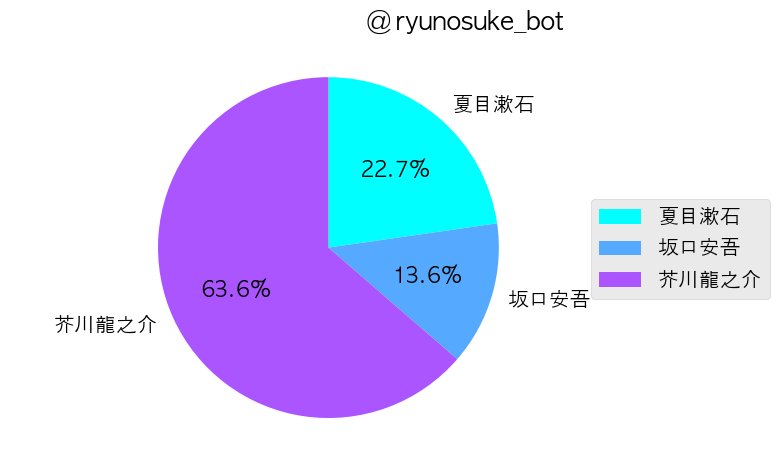

FloatProgress(value=0.0, max=250.0)

The classification by total text is 夏目漱石.


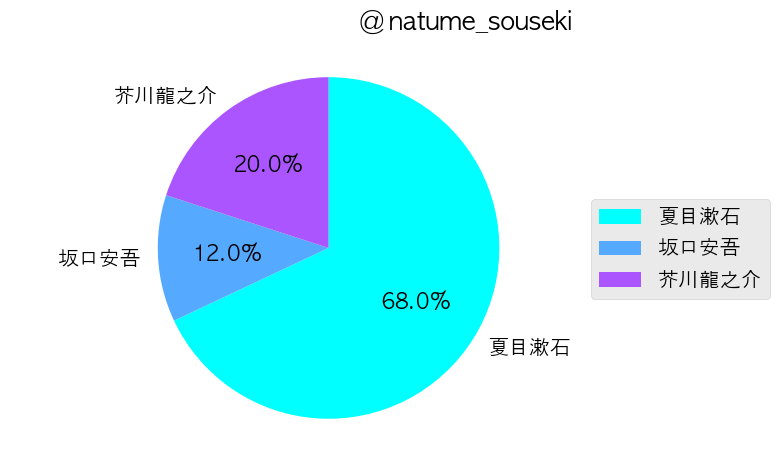

FloatProgress(value=0.0, max=250.0)

The classification by total text is 坂口安吾.


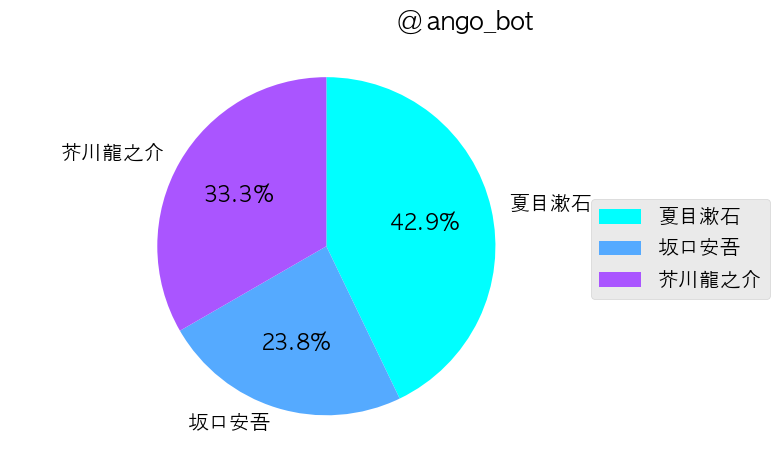

In [13]:
from requests_oauthlib import OAuth1Session
import json
from matplotlib import pyplot as plt

### Constants
oath_key_dict = {
    "consumer_key": "fJCSCXojmlVvVFJ0wfPc56o6H",
    "consumer_secret": "V8Irgqr5lNm2IROKF0I57luXTWfelPKZPHlsfV9tO2MVnGIeex",
    "access_token": "1120358371-5VwFHkA6hYuTWdogSuJBMw4tA0sjlwoj6qHCGHa",
    "access_token_secret": "4nMYjJVR3HBOfWHQjSuI1O33cxebLcLIZnQvVVz8FxRWB"
}

from IPython.display import display
import ipywidgets as widgets
import re
import matplotlib as mpl
font = {"family": "AppleGothic"}
mpl.rc('font', **font)
import matplotlib.cm as cm
import numpy as np
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 15})

size = (9, 5)
writers = ['夏目漱石', '坂口安吾', '芥川龍之介']
col = cm.cool(np.arange(len(writers)) / float(len(writers)))

account_input = widgets.Text(placeholder='Your Twitter Account')
display(account_input)
button = widgets.Button(description="文豪診断")
display(button)

button.on_click(lambda b: diag(account_input.value))


def create_oath_session(oath_key_dict):
    oath = OAuth1Session(
        oath_key_dict["consumer_key"], oath_key_dict["consumer_secret"],
        oath_key_dict["access_token"], oath_key_dict["access_token_secret"])
    return oath


def tweet_search(search_word, oath_key_dict):
    url = "https://api.twitter.com/1.1/search/tweets.json?"
    params = {
        "q": search_word,
        "lang": "ja",
        "result_type": "recent",
        "count": "100"
    }
    oath = create_oath_session(oath_key_dict)
    responce = oath.get(url, params=params)
    if responce.status_code != 200:
        print("Error code: %d" % (responce.status_code))
        return None
    tweets = json.loads(responce.text)
    return tweets


def diag(account_name):
    fp = widgets.FloatProgress(min=0, max=250)
    display(fp)

    # TwitterアカウントIDをsearch, @は削除しておく
    account_name = re.sub('^@', '', account_name)
    tweets = tweet_search("from:" + account_name, oath_key_dict)
    fp.value += 30

    counter = [0, 0, 0]
    for tweet in tweets["statuses"]:
        fp.value += 1
        text = tweet[u'text']
        if '、' not in text:
            continue
        writer = nb.classify(text)
        # print('%s => 推定作者: %s' % (text, writer))
        counter[writers.index(writer)] += 1
    
    text = ''
    for tweet in tweets["statuses"]:
        fp.value += 1
        text += tweet[u'text']
    writer = nb.classify(text)
    print("The classification by total text is " + writer + ".")

    plt.figure(figsize=size, dpi=100)
    plt.pie(
        counter,
        labels=writers,
        colors=col,
        counterclock=False,
        startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 5 else '')
    plt.subplots_adjust(left=0, right=0.7)
    plt.legend(
        writers, fancybox=True, loc='center left', bbox_to_anchor=(0.9, 0.5))
    plt.axis('equal')
    plt.suptitle('＠ ' + account_name)
    # plt.savefig('figure.png',bbox_inches='tight',pad_inches=0.05)

    fp.value += 20
    fp.close()
    return

# 参考文献
金 明哲 自然言語における統計手法を用いた情報処理  2000年3月

金 明哲 村上 征勝 ランダムフォレスト法による文章の書き手の同定  2007年1月

James Conigliaro Author Identification Using Naïve Bayes Classification 